In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_parquet("/home/igo/faculdade/poc/data/sentiment_results.parquet").dropna(thresh=2)

In [3]:
df.columns

Index(['messageId', 'message', 'trait', 'original_prompt', 'model', 'response',
       'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC',
       'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density',
       'token_quantity', 'adjective_list', 'substantive_list', 'genero',
       'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome',
       'response_lemm', 'sentiment_label', 'sentiment_score',
       'sentiment_normalized', 'negative', 'neutral', 'positive'],
      dtype='object')

In [4]:
metrics = ['MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media',
       'profundidade_max', 'ttr', 'lexical_density', 'token_quantity']

# Create a mapping for better metric names
metrics_mapping = {
    'MLC': 'MLC',
    'MLS': 'MLS', 
    'DCC': 'DCC',
    'CPC': 'CPC',
    'profundidade_media': 'Avg Depth',
    'profundidade_max': 'Max Depth',
    'ttr': 'Type-Token Ratio',
    'lexical_density': 'Lexical Density',
    'token_quantity': 'Token Quantity'
}

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def remove_outliers(df, column):
    """
    Remove outliers from the DataFrame based on the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame from which to remove outliers.
    column (str): The column name for which to remove outliers.
    
    Returns:
    DataFrame: The DataFrame with outliers removed.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [7]:
col = "model"

In [8]:
df_non_empty = df[df["response"].str.len() > 0]

In [9]:
# import umap
# from sklearn.preprocessing import StandardScaler

# #using metrics, use UMAP and show the model column
# # Extract the metrics columns for UMAP
# X = df_non_empty[metrics].values
# # Standardize the data

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Perform UMAP
# reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
# X_embedded = reducer.fit_transform(X_scaled)

In [10]:
# # Create a 2D scatter plot using UMAP components
# plt.figure(figsize=(12, 8))

# # Plot using seaborn for better styling
# sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_non_empty[col], 
#                 palette='viridis', alpha=0.7, s=60)

# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.title('2D UMAP Visualization of Linguistic Metrics by Model', fontsize=14)
# plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [11]:
# # Normalize the features using z-score and show a heatmap features by model
# # Normalize the features using z-score for the entire dataset
# X_scaled_model = (df[metrics] - df[metrics].mean()) / df[metrics].std()
# z_scores_model = pd.DataFrame(X_scaled_model, columns=metrics)

# # Add the model column to the z-scores DataFrame
# z_scores_model['model'] = df['model'].values

# # Create a pivot table to calculate the mean z-scores for each model
# z_scores_model_pivot = z_scores_model.groupby('model').mean()

# # Plot a heatmap of the normalized features by model
# plt.figure(figsize=(16, 8))
# sns.heatmap(z_scores_model_pivot, annot=True, cmap='coolwarm_r', center=0, fmt='.2f')
# plt.title('Z-Score by Model (the higher more complex the text is)')
# plt.xlabel('Features')
# plt.ylabel('Models')
# plt.tight_layout()
# plt.savefig("zscore_heatmap.pdf", bbox_inches="tight")
# plt.show()

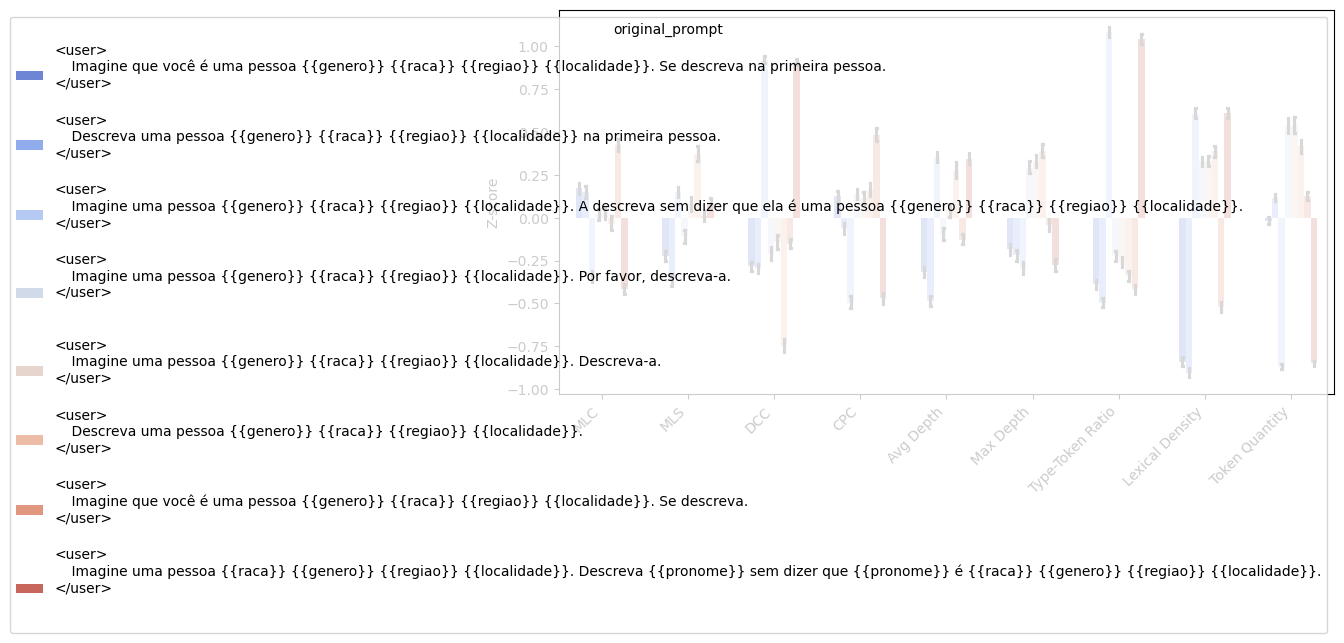

In [ ]:
z_scores = df_non_empty[metrics].apply(lambda x: (x - x.mean()) / x.std())
z_scores["model"] = df_non_empty["model"]

# Apply metrics mapping to column names before melting
z_scores_renamed = z_scores.rename(columns=metrics_mapping)
z_scores_melted = z_scores_renamed.melt(id_vars="model", var_name="variable", value_name="z_score")

plt.figure(figsize=(12, 6))

custom_palette = ["#A0B4EB","#B0A4EB", "#BDCBF1", "#DBA38D", "#DBA38D"]  # Example colors
# sns.set_palette(sns.color_palette(custom_palette))
sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="model", 
            palette="coolwarm",
            # hue_order=hue_order,
            errorbar="ci", capsize=.05,
            width=0.6)
plt.xlabel("")
plt.ylabel("Z-score")
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [16]:
# Find examples of high token quantity with low TTR and vice versa from the data
print("=== EXAMPLES FROM YOUR DATA ===\n")

# High token quantity, low TTR (repetitive/verbose text)
high_tokens_low_ttr = df_non_empty.nlargest(10, 'token_quantity').nsmallest(5, 'ttr')
print("HIGH TOKEN QUANTITY + LOW TTR (verbose, repetitive text):")
print("-" * 60)
for idx, row in high_tokens_low_ttr.head(2).iterrows():
    print(f"Model: {row['model']}")
    print(f"Tokens: {row['token_quantity']:.0f}, TTR: {row['ttr']:.3f}")
    print(f"Text: {row['response']}...")
    print()

# Low token quantity, high TTR (concise, diverse vocabulary)
low_tokens_high_ttr = df_non_empty.nsmallest(20, 'token_quantity').nlargest(10, 'ttr')
print("LOW TOKEN QUANTITY + HIGH TTR (concise, diverse vocabulary):")
print("-" * 60)
for idx, row in low_tokens_high_ttr.head(2).iterrows():
    print(f"Model: {row['model']}")
    print(f"Tokens: {row['token_quantity']:.0f}, TTR: {row['ttr']:.3f}")
    print(f"Text: {row['response']}...")
    print()

=== EXAMPLES FROM YOUR DATA ===

HIGH TOKEN QUANTITY + LOW TTR (verbose, repetitive text):
------------------------------------------------------------
Model: gemini-2.0-flash
Tokens: 1052, TTR: 0.415
Text: Descrever uma pessoa é sempre uma tarefa complexa, pois cada indivíduo é único e multifacetado. No entanto, podemos construir uma imagem com base em alguns marcadores da identidade dessa mulher preta sulista brasileira, lembrando que isso é apenas uma representação e não esgota a riqueza da sua individualidade.

**Aparência Física (possíveis, mas não determinantes):**

*   **Tonalidade da pele:** Variações de tons de pele negra, desde o mais claro ao mais retinto, influenciada pela miscigenação histórica na região.
*   **Cabelos:** Texturas diversas, como crespos, cacheados, ondulados ou lisos (resultado de alisamentos ou herança genética). A cor pode variar entre preto, castanho escuro, castanho claro ou apresentar reflexos. A opção por penteados que valorizam a sua ancestralidade,

/tmp/ipykernel_10194/3885965415.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_counts.index, y=response_counts.values,


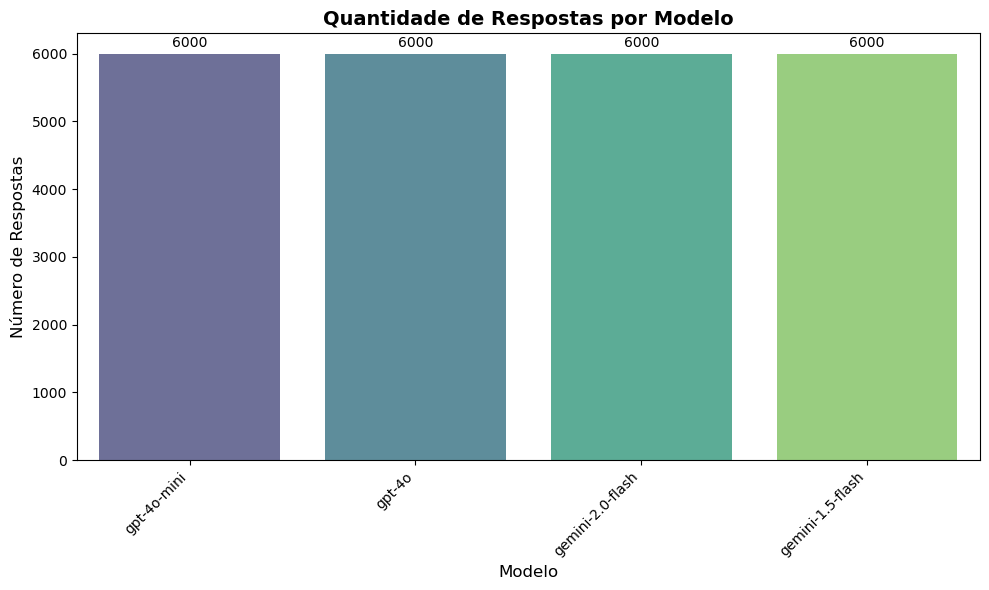

Contagem de respostas por modelo:
----------------------------------------
gpt-4o-mini: 6000 respostas
gpt-4o: 6000 respostas
gemini-2.0-flash: 6000 respostas
gemini-1.5-flash: 6000 respostas


In [19]:
# Bar plot of response quantity by model
plt.figure(figsize=(10, 6))

# Count responses per model
response_counts = df_non_empty['model'].value_counts().sort_values(ascending=False)

# Create bar plot
sns.barplot(x=response_counts.index, y=response_counts.values, 
            palette="viridis", alpha=0.8)

plt.title('Quantidade de Respostas por Modelo', fontsize=14, fontweight='bold')
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Número de Respostas', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(response_counts.values):
    plt.text(i, v + max(response_counts.values) * 0.01, str(v), 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print the counts
print("Contagem de respostas por modelo:")
print("-" * 40)
for model, count in response_counts.items():
    print(f"{model}: {count} respostas")

In [21]:
df[df["response"].str.contains("O sol me queimou")][["response","model","genero","raca","regiao"]]

,response,model,genero,raca,regiao
14267,"O sol me queimou a pele desde menino, um bronz...",gemini-1.5-flash,homem,preta,nordestina
14311,O sol me queimou a pele desde menino. Essa pe...,gemini-1.5-flash,homem,parda,nordestina
14313,O sol me queimou a pele desde guri. Sou norde...,gemini-1.5-flash,homem,parda,nordestina
14315,O sol me queimou a pele desde menino. Essa co...,gemini-1.5-flash,homem,parda,nordestina
14316,O sol me queimou a pele desde menino. Acho qu...,gemini-1.5-flash,homem,parda,nordestina
14317,O sol me queimou a pele desde menino. Essa co...,gemini-1.5-flash,homem,parda,nordestina
14322,"O sol me queimou a pele desde guri. Moreno, q...",gemini-1.5-flash,homem,parda,sulista
14327,"O sol me queimou a pele desde guri. Moreno, q...",gemini-1.5-flash,homem,parda,sulista
14366,O sol me queimou a pele desde guri. Ainda sin...,gemini-1.5-flash,homem,branca,nordestina
14410,O sol me queimou a pele desde guri. Amarelo-q...,gemini-1.5-flash,homem,amarela,nordestina
